In [1]:
filename = "email-Eu-core-temporal.txt"

In [2]:
import pyspark
import itertools
import pyspark
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import time
import csv
import datetime
import matplotlib.pyplot as plt
import numpy as np

# Read data

In [3]:
# create a spark session
spark = SparkSession.builder.appName('link-prediction').getOrCreate()

# read data as list
with open(filename) as csvfile:
    data = [list(map(int, row)) for row in csv.reader(csvfile, delimiter=' ')]

# make a spark dataframe
columns = ["u", "v", "t"]
df = spark.createDataFrame(data=data, schema=columns)

df.toPandas()

23/04/18 15:16:32 WARN Utils: Your hostname, ubuntu-desktop resolves to a loopback address: 127.0.1.1; using 192.168.1.20 instead (on interface enp180s0f0)
23/04/18 15:16:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/18 15:16:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


,u,v,t
0,582,364,0
1,168,472,2797
2,168,912,3304
3,2,790,4523
4,2,322,7926
...,...,...,...
332329,324,367,45401817
332330,790,126,45402441
332331,790,126,45403709
332332,782,126,45404903


# Select based on timeframe

In [4]:
df1 = df.filter(F.col("t") < 20_000_000)

df1.toPandas()

,u,v,t
0,582,364,0
1,168,472,2797
2,168,912,3304
3,2,790,4523
4,2,322,7926
...,...,...,...
135952,24,891,19999819
135953,663,343,19999881
135954,703,863,19999888
135955,530,188,19999909


# Acquire gamma

In [5]:
gamma = df1\
    .select(F.col("u").alias("v"), F.col("v").alias("u"))\
    .union(df1.select(F.col("u"), F.col("v")))\
    .groupby("u")\
    .agg(F.collect_list("v").alias("edges"))\
    .select(F.col("u").alias("node"), F.array_distinct("edges").alias("gamma"), F.size(F.col("edges")).alias("degree"))\
    .select("node", "gamma", F.size("gamma").alias("gamma_size"), "degree")\
    .filter(F.size("gamma") > 2)

gamma.toPandas()

,node,gamma,gamma_size,degree
0,0,"[333, 569, 605, 32, 732, 470, 118, 790, 330, 2...",27,542
1,1,"[309, 106, 323, 324, 310, 548, 103, 399, 46, 3...",13,146
2,2,"[790, 231, 700, 628, 923, 119, 629, 532, 956, ...",73,780
3,4,"[135, 771, 214, 720, 362, 700, 371, 456, 585, ...",19,320
4,5,"[335, 491, 107, 175, 670, 246, 532, 553, 772, ...",36,452
...,...,...,...,...
699,997,"[607, 34, 205, 158, 75, 90, 772, 65, 193, 435,...",18,174
700,999,"[127, 876, 843, 454]",4,10
701,1001,"[685, 738, 106, 506, 850, 90, 977, 410, 14, 82...",42,1078
702,1003,"[291, 707, 609, 268, 890, 443, 454, 592, 75, 4...",13,86


# Acquire intersections and unions of pairs

In [6]:
pairs = gamma \
    .withColumnRenamed("node", "_node") \
    .withColumnRenamed("gamma", "_gamma")\
    .join(gamma) \
    .filter(F.col("node") < F.col("_node"))\
    .select(
        F.col("node").alias("u"), 
        F.col("_node").alias("v"), 
        F.array_intersect("gamma", "_gamma").alias("intersection"),
        F.array_union("gamma", "_gamma").alias("union"),
        "gamma",
        (F.size(F.col("gamma")) * F.size(F.col("_gamma"))).alias("preferential_attachment")
    )

    
pairs.toPandas()

,u,v,intersection,union,gamma,preferential_attachment
0,0,1,[],"[333, 569, 605, 32, 732, 470, 118, 790, 330, 2...","[333, 569, 605, 32, 732, 470, 118, 790, 330, 2...",351
1,0,2,"[569, 790, 178, 693, 423, 991]","[333, 569, 605, 32, 732, 470, 118, 790, 330, 2...","[333, 569, 605, 32, 732, 470, 118, 790, 330, 2...",1971
2,1,2,[322],"[309, 106, 323, 324, 310, 548, 103, 399, 46, 3...","[309, 106, 323, 324, 310, 548, 103, 399, 46, 3...",949
3,0,4,[90],"[333, 569, 605, 32, 732, 470, 118, 790, 330, 2...","[333, 569, 605, 32, 732, 470, 118, 790, 330, 2...",513
4,1,4,[],"[309, 106, 323, 324, 310, 548, 103, 399, 46, 3...","[309, 106, 323, 324, 310, 548, 103, 399, 46, 3...",247
...,...,...,...,...,...,...
247451,996,1004,"[506, 977, 607, 532]","[418, 738, 850, 506, 657, 745, 977, 644, 199, ...","[418, 738, 850, 506, 657, 745, 977, 644, 199, ...",812
247452,997,1004,[607],"[607, 34, 205, 158, 75, 90, 772, 65, 193, 435,...","[607, 34, 205, 158, 75, 90, 772, 65, 193, 435,...",522
247453,999,1004,[],"[127, 876, 843, 454, 977, 189, 335, 175, 236, ...","[127, 876, 843, 454]",116
247454,1001,1004,"[506, 977, 410, 532, 175, 921, 607]","[685, 738, 106, 506, 850, 90, 977, 410, 14, 82...","[685, 738, 106, 506, 850, 90, 977, 410, 14, 82...",1218


# Results

In [7]:
results1 = pairs\
    .select(
        F.concat(F.col("u"), F.lit(","), F.col("v")).alias("u,v"),
        F.size(F.col("intersection")).alias("common_neighbors"),
        (F.size(F.col("intersection"))/(F.size(F.col("union")) + 1e-10)).alias("jaccard_similarity"),
        "preferential_attachment"
    )

results1.toPandas()

,"u,v",common_neighbors,jaccard_similarity,preferential_attachment
0,"0,1",0,0.000000,351
1,"0,2",6,0.063830,1971
2,"1,2",1,0.011765,949
3,"0,4",1,0.022222,513
4,"1,4",0,0.000000,247
...,...,...,...,...
247451,"996,1004",4,0.075472,812
247452,"997,1004",1,0.021739,522
247453,"999,1004",0,0.000000,116
247454,"1001,1004",7,0.109375,1218


In [8]:
split = pairs\
    .select(
        F.concat(F.col("u"), F.lit(","), F.col("v")).alias("u,v"),
        F.explode(pairs.intersection).alias("intersection")
)

split.toPandas()

,"u,v",intersection
0,"0,2",569
1,"0,2",790
2,"0,2",178
3,"0,2",693
4,"0,2",423
...,...,...
343029,"1001,1004",410
343030,"1001,1004",532
343031,"1001,1004",175
343032,"1001,1004",921


In [13]:
results2 = split\
    .join(gamma, split.intersection == gamma.node, "left")\
    .groupby("u,v")\
    .agg(
        F.sum(1/F.log(F.col("gamma_size"))).alias("adamic-adar"),
        F.sum(1/F.col("gamma_size")).alias("resource_allocation"),
        (F.sum(F.col("degree")/F.log(F.col("gamma_size"))).alias("cngf"))
    )

results2.orderBy("u,v").toPandas()

,"u,v",min(gamma_size),adamic-adar,resource_allocation,cngf
0,"0,1001",31.0,0.752598,0.060010,472.026667
1,"0,1004",27.0,1.350224,0.126632,817.678971
2,"0,101",47.0,0.721122,0.049029,559.077120
3,"0,102",NaN,NaN,NaN,NaN
4,"0,103",50.0,0.255622,0.020000,226.992530
...,...,...,...,...,...
108719,"996,997",49.0,0.893318,0.047601,770.795796
108720,"997,1001",128.0,0.411869,0.015564,448.602410
108721,"997,1003",49.0,0.500206,0.036802,315.570015
108722,"997,1004",128.0,0.206099,0.007812,272.875462


# Prediction

In [10]:
keys1 = ["common_neighbors", "jaccard_similarity", "preferential_attachment"]
predictions1 = list(map(lambda key: results1\
    .orderBy(F.col(key).desc())\
    .select("u,v")\
    .rdd\
    .map(lambda row: row[0])\
    .collect(), keys1))

keys2 = ["adamic-adar", "resource_allocation", "cngf"]
predictions2 = list(map(lambda key: results2\
    .orderBy(F.col(key).desc())\
    .select("u,v")\
    .rdd\
    .map(lambda row: row[0])\
    .collect(), keys2))

keys = keys1 + keys2
predictions = predictions1 + predictions2

# ROC curve

In [11]:
df2 = df.filter(F.col("t") >= 20_000_000).filter(F.col("t") < 22_000_000)

labels = df2\
    .filter(F.col("u") < F.col("v"))\
    .select((F.concat(F.col("u"), F.lit(","), F.col("v"))).alias("u,v"))\
    .union(
        df2\
        .filter(F.col("u") > F.col("v"))\
        .select((F.concat(F.col("v"), F.lit(","), F.col("u"))).alias("u,v"))\
    )\
    .distinct();
    
labels = labels\
    .rdd\
    .map(lambda row: row[0])\
    .collect()

len(labels)

3422

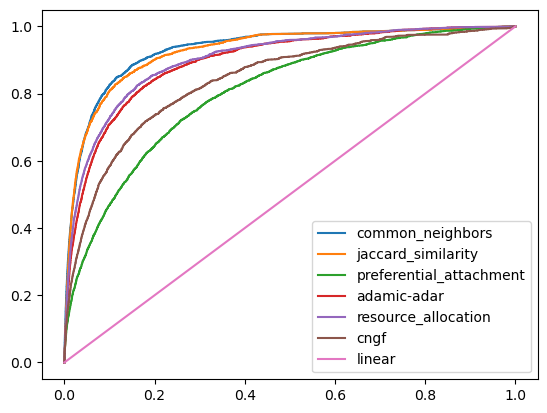

<Figure size 640x480 with 0 Axes>

In [12]:

def roc(pairs, labels):
    labels = set(labels).intersection(set(pairs))
    
    #  threshold = infinite
    tp, fp, fn, tn = 0, 0, len(labels), len(pairs) - len(labels) 
    
    fprs, tprs = [], []
    fprs.append(fp / (fp + tn + 1e-10))
    tprs.append(tp / (tp + fn + 1e-10))
    
    for pair in pairs:
        if pair in labels:
            tp += 1
            fn -= 1
        else:
            fp += 1
            tn -= 1
        fprs.append(fp / (fp + tn + 1e-10))
        tprs.append(tp / (tp + fn + 1e-10))
        
    tp, fp ,fn, tn = len(labels), len(pairs) - len(labels), 0, 0
    fprs.append(fp / (fp + tn + 1e-10))
    tprs.append(tp / (tp + fn + 1e-10))
    
    return fprs, tprs

for key, prediction in zip(keys, predictions):
    fprs, tprs = roc(prediction, labels)
    plt.plot(fprs, tprs, label=key)
plt.plot(np.arange(len(fprs))/len(fprs), np.arange(len(fprs))/len(fprs), label="linear")
plt.legend()
plt.show()
plt.clf()
